In [74]:
from scipy.linalg import eig
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import itertools
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


In [82]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)

# Import seaborn
import seaborn as sns

# Apply the default theme
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="ticks")
sns.despine()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": "60"})

plt.rc('text.latex', preamble=r'\usepackage{braket}\usepackage{amsmath}')

<Figure size 640x480 with 0 Axes>

In [57]:
def convert_script_params_to_filename(script_params):
    # sort keys alphabetically
    sorted_keys = sorted(script_params.keys())
    s = "".join([k + "_" + str(script_params[k]) + "_" for k in sorted_keys])
    return s[:-1] # get rid of trailing underscore


def get_initial_state(name, rng, params=None):
    if name == 'J_zero':
        ham_fname = convert_script_params_to_filename({'s_s': params['n_qubit'],
                                                          'h_bnd': params['h_bnd'],
                                                          'J': 0,
                                                          'seed': params['seed']
                                                          })

        with open('saved_hamiltonians/' + ham_fname + '.pkl', 'rb') as f:
            ham_data = pkl.load(f)
            exact_evals_no_cpl_H = ham_data['evals']
            exact_evecs_no_cpl_H = ham_data['evecs']
           
        exact_evals_evecs_no_cpl_H = {exact_evals_no_cpl_H[i]: exact_evecs_no_cpl_H[:, i] for i in
                                      range(len(exact_evals_no_cpl_H))}
        
        exact_gs_energy_no_cpl_H = min(exact_evals_no_cpl_H)
        reference_state = exact_evals_evecs_no_cpl_H[exact_gs_energy_no_cpl_H]
        # re initialise rng, so when it is called next actual H has same values for hs.
        rng = np.random.default_rng(params['seed'])
    else:
        raise Exception('Initial state: {} not recognised'.format(name))

    return reference_state, rng

def construct_unique_H_elements(matrix_params,
                                size_basis,
                                reference_state,
                                target_H,
                                saved=True):
    
    shot_noise_matrix_params = dict(matrix_params)
    shot_noise_matrix_params['sb_final'] = 2*matrix_params['sb_final']


    if saved:
        matrix_string = convert_script_params_to_filename(shot_noise_matrix_params)

        fname = 'qse_matrices/' + matrix_string

        try:
            unique_H_elements = np.load(fname + '.npy', allow_pickle=True)
            return unique_H_elements.real
        except FileNotFoundError:
            pass

    unique_H_elements = []

    for power in range(0, 2 * size_basis * 2):
        unique_H_elements.append(np.vdot(reference_state,
                                         np.linalg.matrix_power(target_H, power).dot(reference_state)))

    if saved:
        matrix_string = convert_script_params_to_filename(shot_noise_matrix_params)
        fname = 'qse_matrices/' + matrix_string

        np.save(fname, unique_H_elements, allow_pickle=True)

    return np.array(unique_H_elements).real


def compute_qse_matrices_krylov_basis(size_basis,
                                     unique_H_elements,
                                     noise_rng,
                                     noise_type='none',
                                     noise_strength=0):

    # populate these matrices and solve with krylov basis
    H = np.zeros((size_basis, size_basis), dtype=np.float64)

    if noise_strength > 0:  # we don't add noise to 0th element as we know this is 1 for a normalised ref st.
        if noise_type == 'finite_shot_noise':
            unique_H_elements_noisy = add_shot_noise_unique_H_elements(unique_H_elements,
                                                                       size_basis,
                                                                       1 / (noise_strength**2),
                                                                       noise_rng)
        else:
            raise Exception('Noise type {} not recognised'.format(noise_type))
    else:
        unique_H_elements_noisy = list(unique_H_elements[:2*size_basis])

    for i in range(size_basis):  # + 1 index offset to ignore <state|H^0|state> element at i=0
        for j in range(i, size_basis):
            H[i][j] = unique_H_elements_noisy[i + j + 1]

            if i != j:
                H[j][i] = H[i][j]

    S = derive_S_from_H(H, size_basis, normalised_input=False, S_00=unique_H_elements_noisy[0])

    return H, S, unique_H_elements_noisy


def derive_S_from_H(H, size_basis, normalised_input, S_00=None):
    """
        IMPORTANT: for our purposes we expect S and H to be real, regardless of noise. This may not hold for other
        choices for QSE basis i.e. not a Krylov basis.
    """
    S = np.zeros((size_basis, size_basis), dtype=np.float64)

    if normalised_input:
        S[0][0] = 1
    else:
        if S_00 is None:
            raise Exception('Norm must be defined if normalised input is False')
        S[0][0] = S_00

    for i in range(size_basis - 1):
        for j in range(size_basis):
            S[i + 1][j] = H[i][j]

    for i in range(size_basis - 1):
        S[0][i + 1] = H[0][i]

    return S


def add_shot_noise_unique_H_elements(unique_H_elements,
                                     basis_size,
                                     shots,
                                     noise_rng):
    if len(unique_H_elements) < 4*basis_size:
        raise Exception('Need to estimate additional powers of H for shot noise, expected: {}, got: {}'.format(
            4 * basis_size, len(unique_H_elements)
        ))

    noisy_unique_H_elements = [unique_H_elements[0]]

    for i in range(1, int(len(unique_H_elements) / 2)):
        var = unique_H_elements[2*i] - unique_H_elements[i]**2
        std = np.sqrt(var / shots)

        noisy_unique_H_elements.append(unique_H_elements[i] + noise_rng.normal(0, std))

    return noisy_unique_H_elements

def construct_partitioned_qse_mat_cached(size_basis,
                                         unique_H_elements_noisy,
                                         coeff_cache,
                                         matrix_type=np.float64,
                                         cast=True):
    # IMPORTANT: for our purposes we expect S and H to be real, regardless of noise.
    # This may not hold for other choices for QSE basis i.e. not a Krylov basis.
    H = np.zeros((size_basis, size_basis), dtype=matrix_type)
    S = np.zeros((size_basis, size_basis), dtype=matrix_type)

    for idx in range(size_basis):
        for idy in range(size_basis):
            # H[idx][idy] = prec.truncate_negligible_complex(
            #     compute_partitioned_state_power_H_cached(unique_H_elements_noisy, coeff_cache, idx + idy + 1),
            #     1e-10)
            #
            # S[idx][idy] = prec.truncate_negligible_complex(
            #     compute_partitioned_state_power_H_cached(unique_H_elements_noisy, coeff_cache, idx + idy),
            #     1e-10)
            new_H_element = compute_partitioned_state_power_H_cached(unique_H_elements_noisy, coeff_cache, idx + idy + 1)
            new_S_element = compute_partitioned_state_power_H_cached(unique_H_elements_noisy, coeff_cache, idx + idy)

            if cast:
                H[idx][idy] = new_H_element.real
                S[idx][idy] = new_S_element.real
            else:
                H[idx][idy] = new_H_element
                S[idx][idy] = new_S_element


    # assert np.all(H == np.conj(H.T)), 'H not Hermitian:\n{}'.format(H)  # should be Hermitian

    return H, S

def compute_partitioned_state_power_H_cached(unique_H_elements, coeffs, power):
    """
        Unlike compute_partitioned_state_power_H, which figures out how to map from current iteration inner product
        power to unique H elements inner product power, this function takes the unique H elements power as input.
    """
    # matrix element is a weighted sum of inner products and coefficients
    # the inner product Hamiltonian power changes with matrix element indices, but
    # the coefficients are the same for every matrix element at a given
    # partitioned qse iteration

    # the maximum size of `power + _` should be 2 + (2*kbo_final + 1) for the variance check with a terminating KBO.
    # Think about limits:
    # i) single step QSE: 1 coeff = 1 -> return unique_H_elements[power]
    # ii) end of multi iteration PQSE: max(coeffs) = 2*kbo_current, max(power) = kbo_final - max(coeffs)
    return sum(coeffs[_] * unique_H_elements[power + _] for _ in coeffs)


def update_coeff_cache(coeff_cache, new_opt_coeffs, kbo_current):
    new_coeffs_prods = {}

    for new_coeff_idxs in itertools.product(*[range(len(new_opt_coeffs)), range(len(new_opt_coeffs))]):
        coeff_idx_sum = sum(new_coeff_idxs)

        if coeff_idx_sum in new_coeffs_prods:
            new_coeffs_prods[coeff_idx_sum] += np.conj(new_opt_coeffs[new_coeff_idxs[0]]) * new_opt_coeffs[
                new_coeff_idxs[1]]
        else:
            new_coeffs_prods[coeff_idx_sum] = np.conj(new_opt_coeffs[new_coeff_idxs[0]]) * new_opt_coeffs[
                new_coeff_idxs[1]]

    return {m: compute_recombined_coeff(coeff_cache, new_coeffs_prods, m) for m in range(0, (2 * kbo_current) + 1)}


def compute_recombined_coeff(coeff_cache, new_coeffs_prods, m):
    new_coeff = 0

    for j in range(m + 1):
        if m - j in coeff_cache and j in new_coeffs_prods:
            new_coeff += new_coeffs_prods[j] * coeff_cache[m - j]

    return new_coeff

 
                
def find_best_trial_soln_var_running_cached(curr_best_soln,
                                            curr_min_abs_var,
                                            coeff_cache,
                                            unique_H_elements,
                                            kbo_current,
                                            trial_optimal_solns):
    vars = []

    for (coeffs, energy, stored_H, stored_S) in trial_optimal_solns:
        temp_coeff_cache = dict(coeff_cache)

        temp_coeff_cache = update_coeff_cache(temp_coeff_cache,
                                              coeffs,
                                              kbo_current + (len(coeffs) - 1))

        H_10 = compute_partitioned_state_power_H_cached(unique_H_elements,
                                                        temp_coeff_cache,
                                                        2)

        H_00 = compute_partitioned_state_power_H_cached(unique_H_elements,
                                                        temp_coeff_cache,
                                                        1)
        S_00 = compute_partitioned_state_power_H_cached(unique_H_elements,
                                                        temp_coeff_cache,
                                                        0)

        var = compute_var(H_10, H_00, S_00)

        vars.append(var)

        if curr_min_abs_var is None or abs(var) < curr_min_abs_var:
            curr_min_abs_var = abs(var)
            curr_best_soln = (coeffs, energy, stored_H, stored_S)

    return curr_best_soln, curr_min_abs_var, vars


def compute_var(exp_H_sq, exp_H, exp_H_0):
    return (exp_H_sq / exp_H_0) - (exp_H / exp_H_0) ** 2


def apply_thresholding(H, S, threshold):
    """
        Trying to implement the approach detailed in:
        'A THEORY OF QUANTUM SUBSPACE DIAGONALIZATION'
        <link>
    """
    s_evals, s_evecs = eig(S)
    kept_s_evecs = []

    for eval_idx in range(len(s_evals)):
        if s_evals[eval_idx] > threshold:
            kept_s_evecs.append(s_evecs[:, eval_idx])

    if len(kept_s_evecs) == 0:
        raise Exception('No eigenvectors left after thresholding, for KBO {}'.format(len(H) - 1))

    kept_s_evecs = np.transpose(kept_s_evecs)  # get back into eigenvector column format
    thresholded_H = np.dot(np.transpose(np.conj(kept_s_evecs)), np.dot(H, kept_s_evecs))
    thresholded_S = np.dot(np.transpose(np.conj(kept_s_evecs)), np.dot(S, kept_s_evecs))

    return thresholded_H, thresholded_S, kept_s_evecs

def calc_noise_rate(H_noisy, S_noisy, H_no_noise, S_no_noise):
    H_perturbation = H_noisy - H_no_noise
    S_perturbation = S_noisy - S_no_noise

    return np.sqrt(np.linalg.norm(H_perturbation, ord=2) ** 2 + np.linalg.norm(S_perturbation, ord=2) ** 2)


def normalise_vector(v):
    '''
        Returns vector such that |v|**2 = 1

        Parameters:
            v : ndarray : input vector

        Returns:
            ndarray
    '''
    norm_factor = np.sqrt(sum([np.abs(v_i)**2 for v_i in v]))

    if norm_factor == 0:
        raise Exception('Tried to normalise a zero vector')

    return v / norm_factor




In [51]:
def run_pqse(target_H,
             reference_state,
             size_basis_final,
             exact_gs_energy,
             experiment_params,
             exp_data,
             matrix_params,
             noise_rng):

    unique_H_elements = construct_unique_H_elements(matrix_params,
                                                                size_basis_final,
                                                                reference_state,
                                                                target_H)

    _, _, unique_H_elements_noisy = compute_qse_matrices_krylov_basis(size_basis_final,
                                                                              unique_H_elements,
                                                                              noise_rng,
                                                                              noise_type=experiment_params[
                                                                                  'noise_type'],
                                                                              noise_strength=
                                                                              experiment_params[
                                                                                  'noise_str'])

    kbo_current = 0

    optimal_coeffs = []
    counter = 0
    best_soln = None
    curr_min_abs_var = None

    coeff_cache = {0: 1.0}

    while kbo_current < experiment_params['kbo_final']:
        trial_optimal_solns = []  # (coeffs, energy, H, S)

        max_size_basis = (experiment_params['kbo_final'] - kbo_current) + 1

        if len(optimal_coeffs) > 0:
            coeff_cache = update_coeff_cache(coeff_cache, optimal_coeffs[-1], kbo_current)

        for size_basis in range(2, max_size_basis + 1):
            H, S = construct_partitioned_qse_mat_cached(size_basis,
                                                        unique_H_elements_noisy,
                                                        coeff_cache)

            evals, evecs = eig(H, b=S , right=True)

            sorted_evals = np.sort(evals)
            evals_coeffs = {evals[i]: evecs[:, i] for i in range(len(evals))}
            gs_evec = evals_coeffs[sorted_evals[0]]

            if sorted_evals[0].imag < 1e-10:
                #  we can remove imaginary part of energy here as we check if it is negligible above
                trial_optimal_solns.append((gs_evec, sorted_evals[0].real, H, S))

        #  update dependent variables
        if len(trial_optimal_solns) > 0:
            new_best_soln, new_min_abs_var, all_vars = find_best_trial_soln_var_running_cached(best_soln,
                                                                                               curr_min_abs_var,
                                                                                               coeff_cache,
                                                                                               unique_H_elements_noisy,
                                                                                               kbo_current,
                                                                                               trial_optimal_solns)

            if best_soln is None or new_best_soln[1] != best_soln[1]:  # compare energy estimates
                best_soln = new_best_soln
                curr_min_abs_var = new_min_abs_var

                optimal_coeffs.append(best_soln[0])
                kbo_current = kbo_current + (len(optimal_coeffs[-1]) - 1)

                if kbo_current == experiment_params['kbo_final']:
                    exp_data['final_iteration'].append(True)
                else:
                    exp_data['final_iteration'].append(False)
            else:  # no update, terminate
                exp_data['final_iteration'].append(True)

            exp_data['size_basis_current'].append(len(optimal_coeffs[-1]))
            exp_data['iteration_current'].append(counter)
            exp_data['kbo_current'].append(kbo_current)

            temp_coeff_cache = dict(coeff_cache)
            temp_coeff_cache = update_coeff_cache(temp_coeff_cache,
                                                  optimal_coeffs[-1],
                                                  kbo_current)

            state_norm = compute_partitioned_state_power_H_cached(unique_H_elements_noisy,
                                                                  temp_coeff_cache,
                                                                  0)

            energy = best_soln[1]

            exp_data['energy'].append(energy)
            exp_data['energy_err_rel'].append(np.abs(energy - exact_gs_energy) / np.abs(exact_gs_energy))

            if exp_data['final_iteration'][-1]:
                break

            counter += 1
        else:
            exp_data['size_basis_current'].append(exp_data['size_basis_current'][-1]) if len(
                exp_data['size_basis_current']) > 0 else size_basis

            exp_data['iteration_current'].append(counter)
            exp_data['final_iteration'].append(True)
            exp_data['kbo_current'].append(kbo_current)
            exp_data['energy'].append(exp_data['energy'][-1])
            exp_data['energy_target_H'].append(exp_data['energy_target_H'][-1])
            exp_data['energy_err_rel'].append(exp_data['energy_err_rel'][-1])

            print('\nFAILED')
            print('Could not continue iteration')
            print('Experiment parameters')
            print('FAILED\n')
            break

    return exp_data


def run_qse(target_H,
            reference_state,
            size_basis_final,
            exact_gs_energy,
            experiment_params,
            exp_data,
            matrix_params,
            noise_rng):

    unique_H_elements = construct_unique_H_elements(matrix_params,
                                                            size_basis_final,
                                                            reference_state,
                                                            target_H)
    
    H_final, S_final, unique_H_elements_noisy = compute_qse_matrices_krylov_basis(size_basis_final,
                                                                                          unique_H_elements,
                                                                                          noise_rng,
                                                                                          noise_type=experiment_params[
                                                                                              'noise_type'],
                                                                                          noise_strength=
                                                                                          experiment_params[
                                                                                              'noise_str'])

    assert len(unique_H_elements_noisy) == (2 * size_basis_final - 1) + 1  # extra <state|H^0|state> = 1 element at 0th idx

    H_final_no_noise, S_final_no_noise, _ = compute_qse_matrices_krylov_basis(size_basis_final,
                                                                                      unique_H_elements,
                                                                                      noise_rng,
                                                                                       noise_strength=0)

    assert H_final_no_noise.shape == S_final_no_noise.shape and H_final_no_noise.shape == (
        size_basis_final, size_basis_final)

    
    # thresholding
    if experiment_params['thresh']:
        if experiment_params['noise_str'] == 0:
            threshold = 1e-13
        else:
            threshold = np.sqrt(calc_noise_rate(H_final, S_final, H_final_no_noise, S_final_no_noise))

        H, S, kept_s_evecs = apply_thresholding(H_final, S_final, threshold)
    else:
        H, S = H_final, S_final

    evals, evecs = eig(H, b=S , right=True)
    sorted_evals = np.sort(evals)
    evals_coeffs = {evals[i]: evecs[:, i] for i in range(len(evals))}

    eval_0 = sorted_evals[0]

    exp_data['energy'].append(eval_0)
    exp_data['energy_err_rel'].append(np.abs(eval_0 - exact_gs_energy) / np.abs(exact_gs_energy))

    return exp_data

In [52]:
def setup_pqse_experiment():  
    frames = []

    for noise_seed in range(200):
        print('Running PQSE with noise seed: ', noise_seed)
        for kbo_final in range(1, 31):
            # experiment parameters
            experiment_params = {
                'seed': 2,
                'ref_upd': True,  # reference update
                'kbo_final': kbo_final,  # final Krylov basis order
                's_s': 10,  # size state
                'ref_st_name': 'J_zero',  # reference state name
                'noise_type': 'finite_shot_noise',
                'noise_str': 1e-6,  # noise strength
                'n_seed': noise_seed,
                'thold': 'None',
                'J': 0.1,  # inter spin coupling
                'h_bnd': 1  # bound on magnitude of on site disorder
            }

            frames.append(run_pqse_experiment(experiment_params))
    
    return pd.concat(frames)
                    
                    
def run_pqse_experiment(experiment_params):
    exp_data = {
        'size_state': [],
        'seed': [],
        'J': [],
        'h_bound': [],
        'reference_update': [],
        'noise_strength': [],
        'noise_type': [],
        'noise_seed': [],
        'init_reference_state': [],
        'size_basis_current': [],
        'iteration_current': [],
        'final_iteration': [],
        'kbo_final': [],
        'kbo_current': [],
        'exact_energy': [],
        'energy': [],
        'energy_err_rel': [],

    }

    rng = np.random.default_rng(experiment_params['seed'])
    noise_rng = np.random.default_rng(experiment_params['n_seed'])

    reference_state, rng = get_initial_state(experiment_params['ref_st_name'],
                                             rng,
                                             params={'J': experiment_params['J'],
                                                     'h_bnd': experiment_params['h_bnd'],
                                                     'seed': experiment_params['seed'],
                                                     'n_qubit': experiment_params['s_s']})

    reference_state = normalise_vector(reference_state)
    
    ham_fname = convert_script_params_to_filename({'s_s': experiment_params['s_s'],
                                                   'h_bnd': experiment_params['h_bnd'],
                                                   'J': experiment_params['J'],
                                                   'seed': experiment_params['seed']
                                                          })

    with open('saved_hamiltonians/' + ham_fname + '.pkl', 'rb') as f:
        ham_data = pkl.load(f)
        target_H = ham_data['H']
        exact_evals = ham_data['evals']
        
    exact_gs_energy = min(exact_evals)
   
    size_basis_final = experiment_params['kbo_final'] + 1 + 1  # extra + 1 for gradient norm calculation

    matrix_params = {
        'sb_final': size_basis_final,
        'ref_st_name': experiment_params['ref_st_name'],
        'seed': experiment_params['seed'],
        'J': experiment_params['J'],
        'h_bnd': experiment_params['h_bnd']
    }

    exp_data = run_pqse(target_H,
                        reference_state,
                        size_basis_final,
                        exact_gs_energy,
                        experiment_params,
                        exp_data,
                        matrix_params,
                        noise_rng)

    # populate constant data points
    for _ in range(len(exp_data['energy'])):  # take an arbitrary parameter to learn number of data points
        exp_data['size_state'].append(experiment_params['s_s'])
        exp_data['seed'].append(experiment_params['seed'])
        exp_data['J'].append(experiment_params['J'])
        exp_data['h_bound'].append(experiment_params['h_bnd'])
        exp_data['reference_update'].append(experiment_params['ref_upd'])
        exp_data['noise_strength'].append(experiment_params['noise_str'])
        exp_data['noise_type'].append(experiment_params['noise_type'])
        exp_data['noise_seed'].append(experiment_params['n_seed'])
        exp_data['init_reference_state'].append(experiment_params['ref_st_name'])
        exp_data['kbo_final'].append(experiment_params['kbo_final'])
        exp_data['exact_energy'].append(exact_gs_energy)
     
    return pd.DataFrame(exp_data)


In [59]:
def setup_qse_experiment(thresholding=False):
    frames = []

    for noise_seed in range(200):
        if thresholding:
            print('Running TQSE with noise seed: ', noise_seed)
        else:
            print('Running QSE with noise seed: ', noise_seed)
            
        for kbo_final in range(1, 16):
            experiment_params = {
                'seed': 2,
                'kbo_init': kbo_final,  # initial Krylov basis order
                'kbo_final': kbo_final,  # final Krylov basis order
                'ref_st_name': 'J_zero',  # reference state name
                'noise_type': 'finite_shot_noise',
                'noise_str': 1e-6,  # noise strength
                'n_seed': noise_seed,
                'thresh': thresholding,  # thresholding
                # problem specific params
                's_s': 10,  # size state
                'J': 0.1,  # inter spin coupling
                'h_bnd': 1  # bound on magnitude of on site disorder
            }

            frames.append(run_qse_experiment(experiment_params))

    return pd.concat(frames)

                  
def run_qse_experiment(experiment_params):
    exp_data = {
        'size_state': [],
        'noise_strength': [],
        'noise_type': [],
        'noise_seed': [],
        'thresholding': [],
        'init_reference_state': [],
        'kbo_final': [],
        'exact_energy': [],
        'energy': [],
        'energy_err_rel': [],
    }

    N = 2 ** experiment_params['s_s']
    rng = np.random.default_rng(experiment_params['seed'])
    noise_rng = np.random.default_rng(experiment_params['n_seed'])

    reference_state, rng = get_initial_state(experiment_params['ref_st_name'],
                                             rng,
                                             params={'J': experiment_params['J'],
                                                     'h_bnd': experiment_params['h_bnd'],
                                                     'seed': experiment_params['seed'],
                                                     'n_qubit': experiment_params['s_s']})

    reference_state = normalise_vector(reference_state)

    ham_fname = convert_script_params_to_filename({'s_s': experiment_params['s_s'],
                                                      'h_bnd': experiment_params['h_bnd'],
                                                      'J': experiment_params['J'],
                                                      'seed': experiment_params['seed']
                                                      })

    with open('saved_hamiltonians/' + ham_fname + '.pkl', 'rb') as f:
        ham_data = pkl.load(f)
        target_H = ham_data['H']
        exact_evals = ham_data['evals']

    tr_H = sum([target_H[i][i] for i in range(len(target_H))])

    exact_gs_energy = min(exact_evals)

    size_basis_final = experiment_params['kbo_final'] + 1

    matrix_params = {
        'sb_final': size_basis_final,
        'ref_st_name': experiment_params['ref_st_name'],
        'seed': experiment_params['seed'],
        'J': experiment_params['J'],
        'h_bnd': experiment_params['h_bnd']
    }
    
    exp_data = run_qse(target_H,
                           reference_state,
                           size_basis_final,
                           exact_gs_energy,
                           experiment_params,
                           exp_data,
                           matrix_params,
                           noise_rng)

    # populate constant data points
    n_qubits = int(np.log2(len(reference_state)))
    for _ in range(len(exp_data['energy'])):  # take an arbitrary parameter to learn number of data points
        exp_data['size_state'].append(experiment_params['s_s'])
        exp_data['noise_strength'].append(experiment_params['noise_str'])
        exp_data['noise_type'].append(experiment_params['noise_type'])
        exp_data['noise_seed'].append(experiment_params['n_seed'])
        exp_data['init_reference_state'].append(experiment_params['ref_st_name'])
        exp_data['thresholding'].append(experiment_params['thresh'])
        exp_data['kbo_final'].append(experiment_params['kbo_final'])
        exp_data['exact_energy'].append(exact_gs_energy)

    return pd.DataFrame(exp_data)



In [60]:
qse_df = setup_qse_experiment(thresholding=False)

Running QSE with noise seed:  0
Running QSE with noise seed:  1
Running QSE with noise seed:  2
Running QSE with noise seed:  3
Running QSE with noise seed:  4
Running QSE with noise seed:  5
Running QSE with noise seed:  6
Running QSE with noise seed:  7
Running QSE with noise seed:  8
Running QSE with noise seed:  9
Running QSE with noise seed:  10
Running QSE with noise seed:  11
Running QSE with noise seed:  12
Running QSE with noise seed:  13
Running QSE with noise seed:  14
Running QSE with noise seed:  15
Running QSE with noise seed:  16
Running QSE with noise seed:  17
Running QSE with noise seed:  18
Running QSE with noise seed:  19
Running QSE with noise seed:  20
Running QSE with noise seed:  21
Running QSE with noise seed:  22
Running QSE with noise seed:  23
Running QSE with noise seed:  24
Running QSE with noise seed:  25
Running QSE with noise seed:  26
Running QSE with noise seed:  27
Running QSE with noise seed:  28
Running QSE with noise seed:  29
Running QSE with noi

In [61]:
tqse_df = setup_qse_experiment(thresholding=True)

Running TQSE with noise seed:  0
Running TQSE with noise seed:  1
Running TQSE with noise seed:  2
Running TQSE with noise seed:  3
Running TQSE with noise seed:  4
Running TQSE with noise seed:  5
Running TQSE with noise seed:  6
Running TQSE with noise seed:  7
Running TQSE with noise seed:  8
Running TQSE with noise seed:  9
Running TQSE with noise seed:  10
Running TQSE with noise seed:  11
Running TQSE with noise seed:  12
Running TQSE with noise seed:  13
Running TQSE with noise seed:  14
Running TQSE with noise seed:  15
Running TQSE with noise seed:  16
Running TQSE with noise seed:  17
Running TQSE with noise seed:  18
Running TQSE with noise seed:  19
Running TQSE with noise seed:  20
Running TQSE with noise seed:  21
Running TQSE with noise seed:  22
Running TQSE with noise seed:  23
Running TQSE with noise seed:  24
Running TQSE with noise seed:  25
Running TQSE with noise seed:  26
Running TQSE with noise seed:  27
Running TQSE with noise seed:  28
Running TQSE with noise 

In [58]:
pqse_df = setup_pqse_experiment()

Running PQSE with noise seed:  0
Running PQSE with noise seed:  1
Running PQSE with noise seed:  2
Running PQSE with noise seed:  3
Running PQSE with noise seed:  4
Running PQSE with noise seed:  5
Running PQSE with noise seed:  6
Running PQSE with noise seed:  7
Running PQSE with noise seed:  8
Running PQSE with noise seed:  9
Running PQSE with noise seed:  10
Running PQSE with noise seed:  11
Running PQSE with noise seed:  12
Running PQSE with noise seed:  13
Running PQSE with noise seed:  14
Running PQSE with noise seed:  15
Running PQSE with noise seed:  16
Running PQSE with noise seed:  17
Running PQSE with noise seed:  18
Running PQSE with noise seed:  19
Running PQSE with noise seed:  20
Running PQSE with noise seed:  21
Running PQSE with noise seed:  22
Running PQSE with noise seed:  23
Running PQSE with noise seed:  24
Running PQSE with noise seed:  25
Running PQSE with noise seed:  26
Running PQSE with noise seed:  27
Running PQSE with noise seed:  28
Running PQSE with noise 

/var/folders/gb/4x7sxfxn0td96_v9szy0_klc0000gq/T/ipykernel_18682/2485932083.py:260: RuntimeWarning: divide by zero encountered in scalar divide
  return (exp_H_sq / exp_H_0) - (exp_H / exp_H_0) ** 2
/var/folders/gb/4x7sxfxn0td96_v9szy0_klc0000gq/T/ipykernel_18682/2485932083.py:260: RuntimeWarning: invalid value encountered in scalar divide
  return (exp_H_sq / exp_H_0) - (exp_H / exp_H_0) ** 2


Running PQSE with noise seed:  48
Running PQSE with noise seed:  49
Running PQSE with noise seed:  50
Running PQSE with noise seed:  51
Running PQSE with noise seed:  52
Running PQSE with noise seed:  53
Running PQSE with noise seed:  54
Running PQSE with noise seed:  55
Running PQSE with noise seed:  56
Running PQSE with noise seed:  57
Running PQSE with noise seed:  58
Running PQSE with noise seed:  59
Running PQSE with noise seed:  60
Running PQSE with noise seed:  61
Running PQSE with noise seed:  62
Running PQSE with noise seed:  63
Running PQSE with noise seed:  64
Running PQSE with noise seed:  65
Running PQSE with noise seed:  66
Running PQSE with noise seed:  67
Running PQSE with noise seed:  68
Running PQSE with noise seed:  69
Running PQSE with noise seed:  70
Running PQSE with noise seed:  71
Running PQSE with noise seed:  72
Running PQSE with noise seed:  73
Running PQSE with noise seed:  74
Running PQSE with noise seed:  75
Running PQSE with noise seed:  76
Running PQSE w

### Dataframe functions

In [62]:
def get_rel_err_ave_energy_df(df: pd.DataFrame, drop_columns: list, group_columns: list):    
    aggregated_df = df.drop(drop_columns, axis=1).groupby(group_columns).aggregate(['mean', 'sem'])
    aggregated_df['rel_err_ave_energy'] = aggregated_df.apply(lambda row : np.abs(row['energy']['mean'] - row['exact_energy']['mean']) / np.abs(row['exact_energy']['mean']), axis=1)    
    aggregated_df['rel_err_ave_energy_sem'] = aggregated_df['energy']['sem'] / np.abs(aggregated_df['exact_energy']['mean'])
    aggregated_df = aggregated_df.reset_index()
    
    return aggregated_df

In [67]:
ave_error_qse_df = get_rel_err_ave_energy_df(qse_df, 
                                                    ['noise_type', 'init_reference_state'], 
                                                    ['noise_strength', 'kbo_final'])

ave_error_tqse_df = get_rel_err_ave_energy_df(tqse_df, 
                                                    ['noise_type', 'init_reference_state'], 
                                                    ['noise_strength', 'kbo_final'])


ave_error_pqse_df = get_rel_err_ave_energy_df(pqse_df, 
                                                    ['noise_type', 'init_reference_state'], 
                                                    ['noise_strength', 'reference_update', 'kbo_final'])


/Users/oleary/opt/anaconda3/envs/qse/lib/python3.8/site-packages/pandas/core/groupby/groupby.py:3795: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/oleary/opt/anaconda3/envs/qse/lib/python3.8/site-packages/pandas/core/groupby/groupby.py:3795: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)


Text(0.88, 0.94, '$\\delta =$ 1e-06')

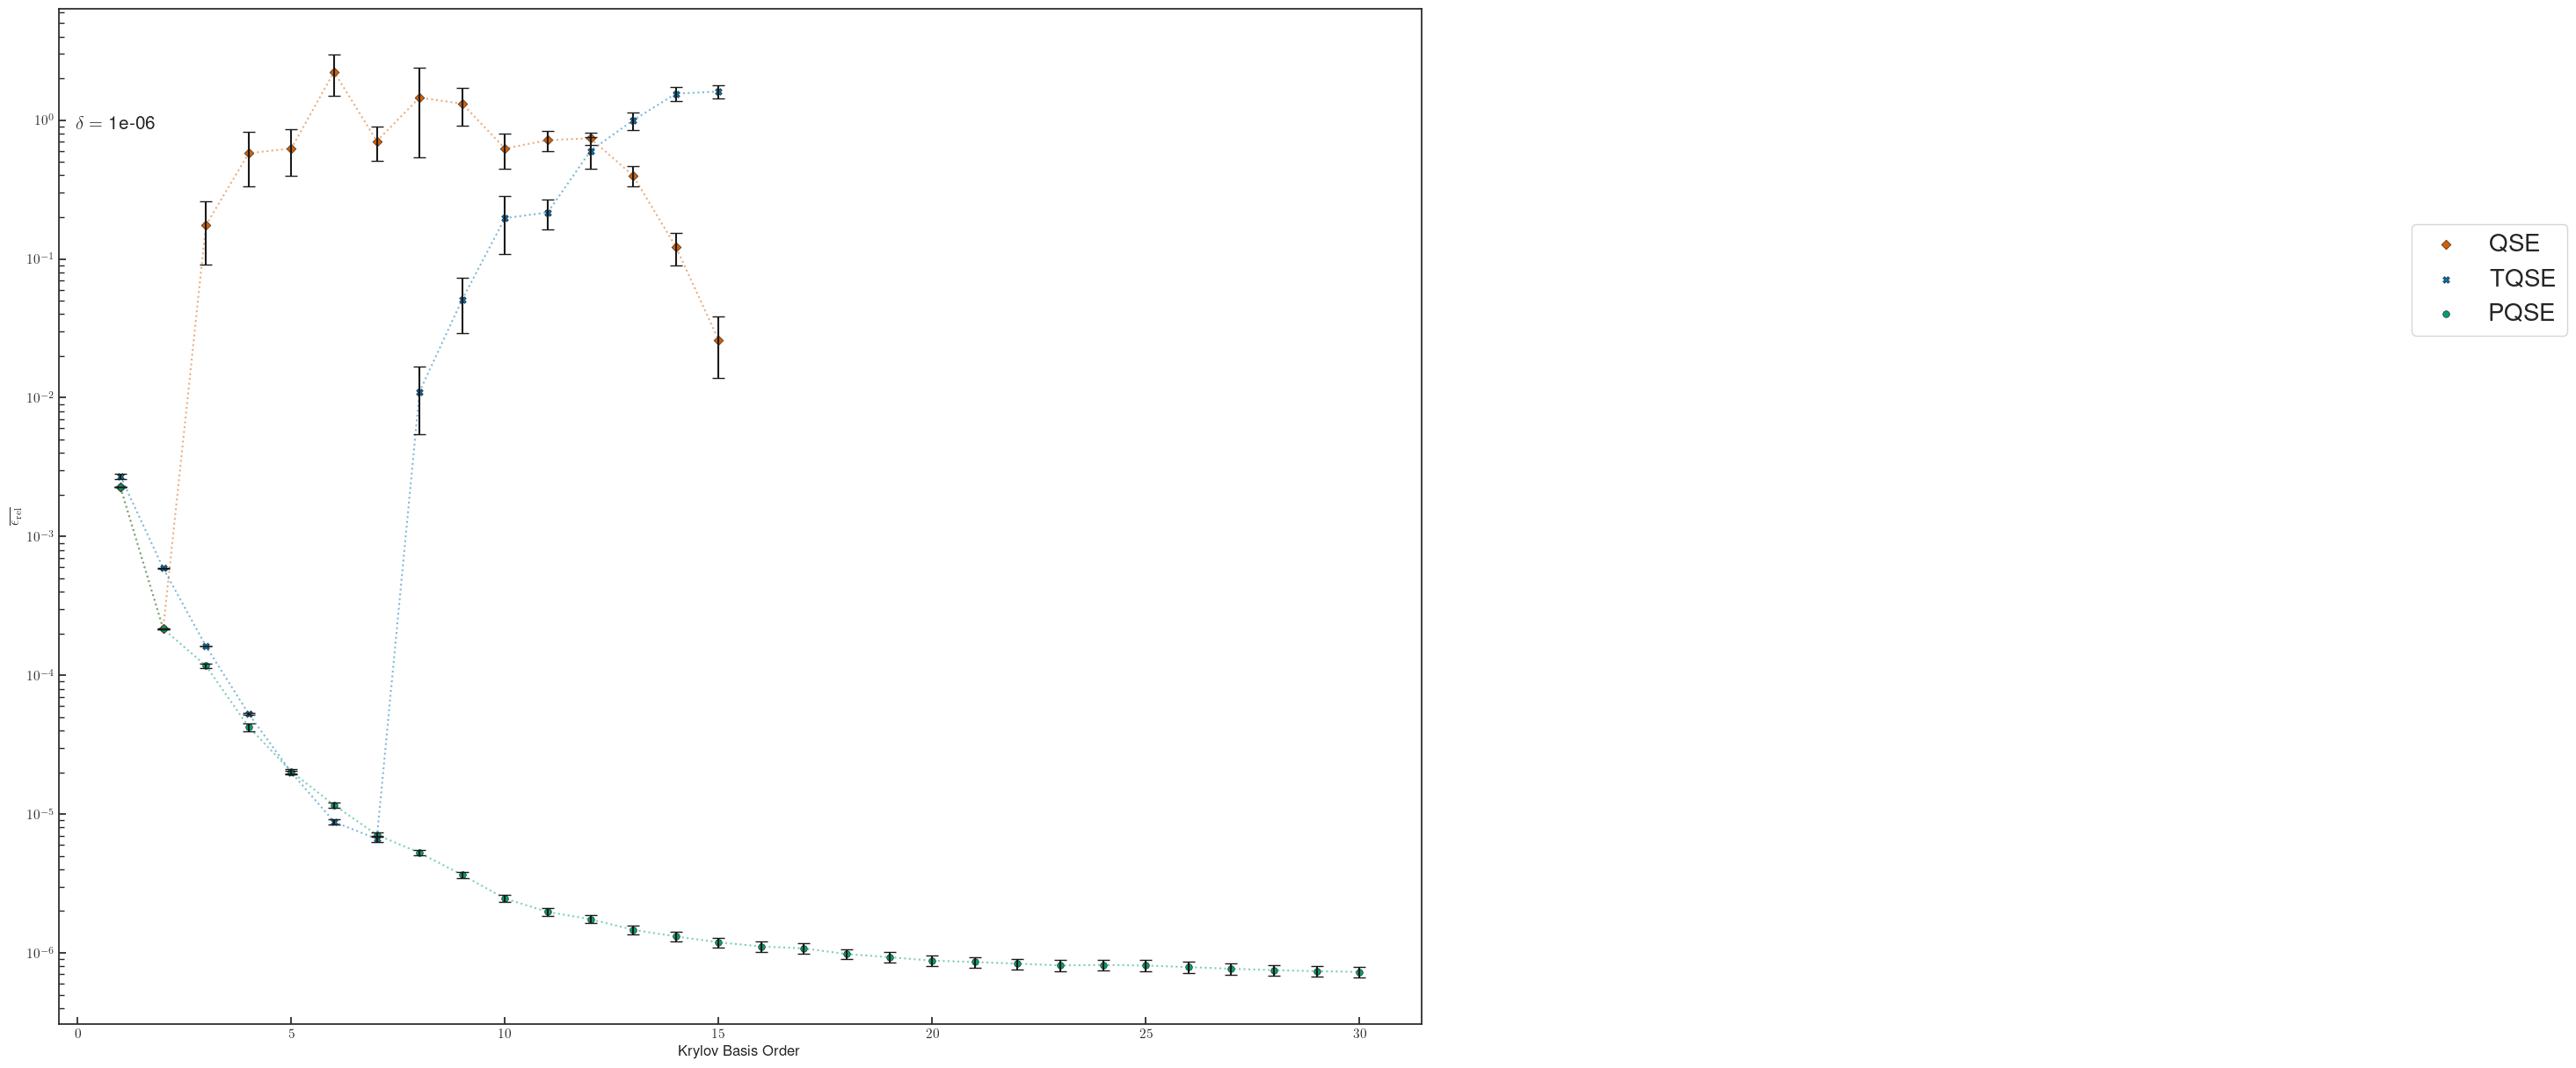

In [83]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(20,15))

markers = ['D', 'X', 'o']

colors = [_ for (idx, _) in enumerate(sns.color_palette("colorblind")) if idx != 1][:3]
colors = [colors[2], colors[0], colors[1]]

noise_strength = 1e-6

kwargs  =   {'edgecolor':"k", # for edge color
             's': 30
            }

# QSE
qse_scatter_plot = sns.scatterplot(
    data=ave_error_qse_df,
    x='kbo_final', 
    y=('energy_err_rel', 'mean'), marker=markers[0], color=colors[0], **kwargs, label='QSE', legend=None)


sns.lineplot(
    data=ave_error_qse_df,
    x='kbo_final', 
    y=('energy_err_rel', 'mean'),
    estimator=None, ls=':', color=colors[0], alpha=0.5, legend=None, markers=False)

plt.errorbar(ave_error_qse_df['kbo_final'], 
             ave_error_qse_df['energy_err_rel']['mean'], 
             ave_error_qse_df['energy_err_rel']['sem'], 
              capsize=5, ecolor='k', marker="none", ls="None")


# TQSE
sns.lineplot(
    data=ave_error_tqse_df,
    x='kbo_final', 
    y=('energy_err_rel', 'mean'),
    estimator=None, color=colors[1], ls=':', alpha=0.5, legend=None)


thqse_scatter_plot = sns.scatterplot(
    data=ave_error_tqse_df,
    x='kbo_final', 
    y=('energy_err_rel', 'mean'), marker=markers[1], color=colors[1],  **kwargs, label='TQSE', legend=None)

plt.errorbar(ave_error_tqse_df['kbo_final'], 
             ave_error_tqse_df['energy_err_rel']['mean'], 
             ave_error_tqse_df['energy_err_rel']['sem'], 
             capsize=5, ecolor='k', marker="none", ls="None")

# PQSE
sns.lineplot(
    data=ave_error_pqse_df,
    x='kbo_final', 
    y=('energy_err_rel', 'mean'),
    estimator=None, color=colors[2], ls=':', alpha=0.5, legend=None)

sns.scatterplot(
    data=ave_error_pqse_df,
    x='kbo_final', 
    y=('energy_err_rel', 'mean'), marker=markers[2], color=colors[2], **kwargs, label='PQSE', legend=None)

plt.errorbar(
             ave_error_pqse_df['kbo_final'], 
             ave_error_pqse_df['energy_err_rel']['mean'], 
             ave_error_pqse_df['energy_err_rel']['sem'], 
             capsize=5, ecolor='k', marker="none", ls="None")


qse_scatter_plot.set(ylabel=r'$\overline{\epsilon_{\textrm{rel}}}$',  xlabel='Krylov Basis Order')
qse_scatter_plot.set(yscale="log")

plt.legend(fontsize=20, bbox_to_anchor=(1.85, 0.8))


plt.tick_params(which='both', direction='in')

plt.text(0.88, 0.94, 
     r'$\delta =$ {}'.format(noise_strength), 
     va="center", 
     ha="center", 
     fontsize=15)

    
